**Kelompok 1**
---
*   Alifia Listu Samatha
*   Anindya Widi
*   Agung Besti


# **Import Data**

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [226]:
df = pd.read_csv('/content/drive/My Drive/OnlineRetail.csv', encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# **Data Understanding**

In [227]:
# 1) Data Understanding
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
object     5
float64    2
int64      1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
CustomerID,float64,406829,4373,135080,12346
Description,object,540455,4224,1454,NaN
Country,object,541909,38,0,Australia
InvoiceDate,object,541909,23260,0,1/10/2011 10:04
InvoiceNo,object,541909,25900,0,536365
Quantity,int64,541909,722,0,-80995
StockCode,object,541909,4070,0,10002
UnitPrice,float64,541909,1630,0,-11062.1


Dari tabel summary di atas, terdapat beberapa hal yang perlu ditinjau ulang:

1) Null Values
Kolom **CustomerID** dan **Description** memiliki null values

2) Nilai Negatif
**Quantity** dan **UnitPrice** seharusnya memiliki nilai >= 0, tetapi dari summary di atas terdapat nilai negatif untuk dua kolom tersebut

In [228]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [229]:
# Cek ada berapa negative values
print('% Total Negative Value (Quantity): {:3.2%}'.format(df[(df.Quantity<0)].shape[0]/df.shape[0]))
print('% Total Negative Value (Unit Price): {:3.2%}'.format(df[(df.UnitPrice<0)].shape[0]/df.shape[0]))

% Total Negative Value (Quantity): 1.96%
% Total Negative Value (Unit Price): 0.00%


In [230]:
# Cek ada berapa row bernilai nol (zero)
print('% Total Zero Value (Quantity): {:3.2%}'.format(df[(df.Quantity==0)].shape[0]/df.shape[0]))
print('% Total Zero Value (Unit Price): {:3.2%}'.format(df[(df.UnitPrice==0)].shape[0]/df.shape[0]))

% Total Zero Value (Quantity): 0.00%
% Total Zero Value (Unit Price): 0.46%


# **Data Cleaning**

In [231]:
# 2) Data Cleaning
# Drop CustomerID dengan null value
df = df[~(df.CustomerID.isnull())]

# Drop value yang bernilai negatif dan/atau return transaction (Unit Price < 0)
df = df[~(df.Quantity<0)]
df = df[df.UnitPrice>0]

# Cek kembali tabel summary
details = summary(df)
display(details.sort_values(by='uniques', ascending=False))

Data shape: (397884, 8)
___________________________
Data types:
object     5
float64    2
int64      1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
InvoiceNo,object,397884,18532,0,536365
InvoiceDate,object,397884,17282,0,1/10/2011 10:32
CustomerID,float64,397884,4338,0,12346
Description,object,397884,3877,0,4 PURPLE FLOCK DINNER CANDLES
StockCode,object,397884,3665,0,10002
UnitPrice,float64,397884,440,0,0.001
Quantity,int64,397884,301,0,1
Country,object,397884,37,0,Australia


In [232]:
# Masih terdapat nilai unique Description > StockCode (inkonsistensi data)
cat_des_df = df.groupby(["StockCode","Description"]).count().reset_index()
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head())
df[df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][4]]['Description'].unique()

,index,StockCode
0,23236,4
1,23196,4
2,23370,3
3,23244,3
4,23126,3


array(['DOLLCRAFT GIRL AMELIE KIT', 'FELTCRAFT GIRL AMELIE KIT',
       'DOLLCRAFT GIRL AMELIE'], dtype=object)

In [233]:
!pip install pandasql

In [234]:
# Setelah dicek, masih terdapat typo pada jenis item yang sama
# Inner Join untuk mengambil data yang sama saja

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

unique_desc = df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from df as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

df = pysqldf(q)

In [235]:
# Convert format to datetime
from datetime import datetime
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df.CustomerID = df.CustomerID.astype('Int64')

details = summary(df)
display(details.sort_values(by='uniques', ascending=False))

Data shape: (397884, 8)
___________________________
Data types:
object            4
int64             1
Int64             1
datetime64[ns]    1
float64           1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
InvoiceNo,object,397884,18532,0,536365
InvoiceDate,datetime64[ns],397884,17282,0,2010-12-01 08:26:00
CustomerID,Int64,397884,4338,0,12346
StockCode,object,397884,3665,0,10002
Description,object,397884,3647,0,4 PURPLE FLOCK DINNER CANDLES
UnitPrice,float64,397884,440,0,0.001
Quantity,int64,397884,301,0,1
Country,object,397884,37,0,Australia


In [236]:
# Cek ada berapa negara
df.Country.nunique()

37

In [237]:
# Cek jumlah Customer per Country
customer_country = df[['Country','CustomerID']].drop_duplicates()
cust_group = customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID',ascending=False)
cust_group.head()

,Country,CustomerID
35,United Kingdom,3920
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25


In [238]:
# Insert kolom baru (Total Price)
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [239]:
grouped_2 = df.groupby('Country', as_index=False,).agg({'TotalPrice':'sum'})
sorted_2 = grouped_2.sort_values(by='TotalPrice', ascending=False)
top_10 = sorted_2[:10]
top_10

,Country,TotalPrice
35,United Kingdom,7.308392e+06
23,Netherlands,2.854463e+05
10,EIRE,2.655459e+05
14,Germany,2.288671e+05
13,France,2.090240e+05
0,Australia,1.385213e+05
30,Spain,6.157711e+04
32,Switzerland,5.644395e+04
3,Belgium,4.119634e+04
31,Sweden,3.837833e+04


In [240]:
grouped_1 = df.groupby('Description', as_index=False,).agg({'TotalPrice':'sum'})
sorted_1 = grouped_1.sort_values(by='TotalPrice', ascending=False)
sorted_1['cum_sum'] = sorted_1['TotalPrice'].cumsum()
sorted_1['cum_perc'] = 100*sorted_1['cum_sum']/sorted_1['TotalPrice'].sum()
sorted_1['cum_perc'] = sorted_1['cum_perc'].round(decimals=2)
top_item = sorted_1.reset_index(drop=True)
top_item

,Description,TotalPrice,cum_sum,cum_perc
0,"PAPER CRAFT , LITTLE BIRDIE",168469.600,168469.600,1.89
1,REGENCY CAKESTAND 3 TIER,142592.950,311062.550,3.49
2,WHITE HANGING HEART T-LIGHT HOLDER,100603.500,411666.050,4.62
3,JUMBO BAG RED RETROSPOT,85220.780,496886.830,5.58
4,MEDIUM CERAMIC TOP STORAGE JAR,81416.730,578303.560,6.49
...,...,...,...,...
3642,PINK CRYSTAL GUITAR PHONE CHARM,0.850,8911405.791,100.00
3643,PURPLE FRANGIPANI HAIRCLIP,0.850,8911406.641,100.00
3644,VINTAGE BLUE TINSEL REEL,0.840,8911407.481,100.00
3645,HEN HOUSE W CHICK IN NEST,0.420,8911407.901,100.00


In [241]:
idx = top_item[top_item['cum_perc'] == 80.01]
idx

,Description,TotalPrice,cum_sum,cum_perc
776,ENAMEL WATERING CAN CREAM,2646.6,7129884.41,80.01


In [242]:
777/3647*100

21.30518234165067

80% hasil penjualan berasal dari 21,30% keseluruhan item dengan penjualan paling banyak (dari segi pemasukan)

In [243]:
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / 8911407.904
    cumsum = weights.cumsum()

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.bar(x, y)
    ax1.set_xlabel(xlabel, rotation='horizontal')
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('test.png')

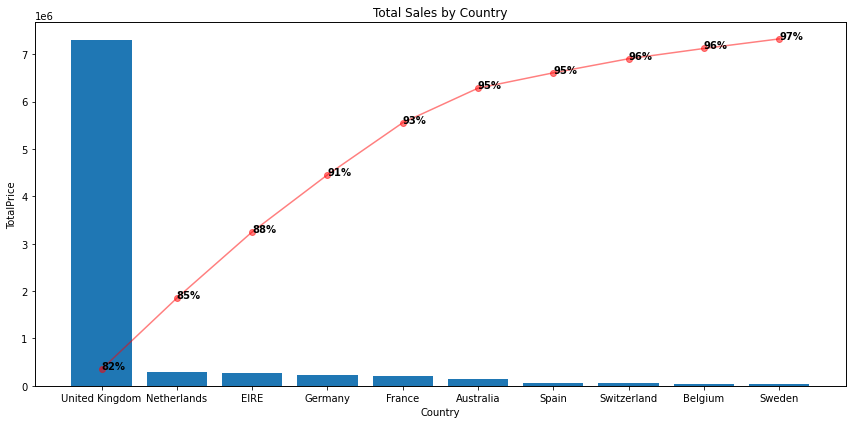

<Figure size 432x288 with 0 Axes>

In [244]:
pareto_plot(top_10, x='Country', y='TotalPrice', title='Total Sales by Country')

In [245]:
df.TotalPrice.sum()

8911407.904

# **Exploratory Data Analysis**

Text(0.5, 1.0, 'Top 10 Items Sold')

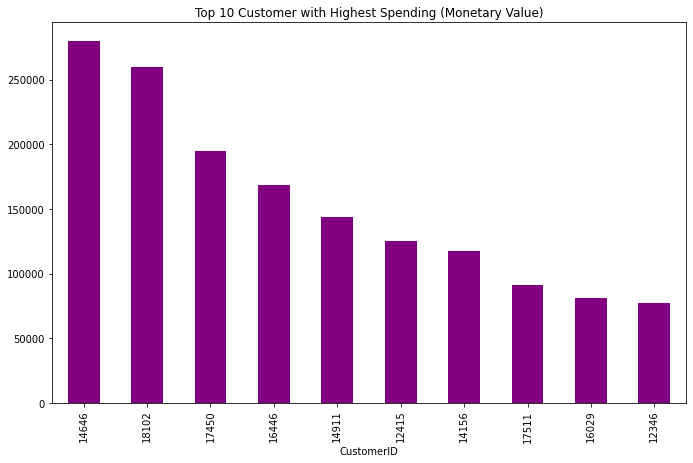

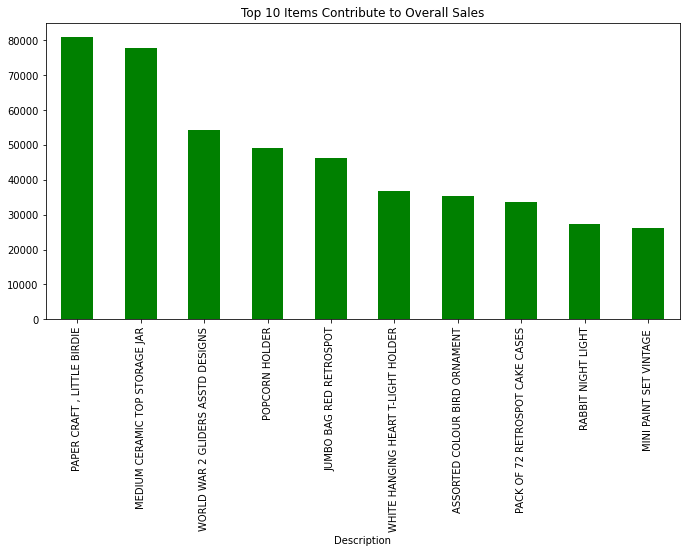

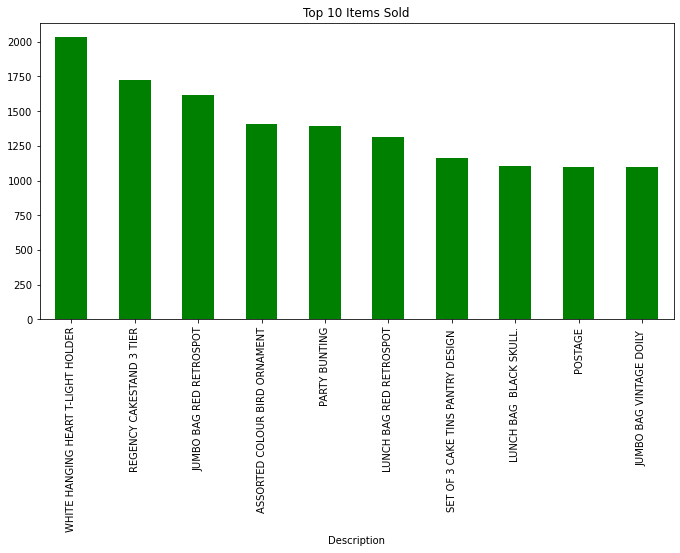

In [246]:
# EDA
# Sales per Customer
fig = plt.figure(figsize=(25, 7))
f2 = fig.add_subplot(122)
g = df.groupby(["CustomerID"]).TotalPrice.sum().sort_values(ascending = False)[:10].plot(kind='bar', title='Amount Sales by Country', color='purple')
plt.title('Top 10 Customer with Highest Spending (Monetary Value)')

# Sales per StockCode
fig = plt.figure(figsize=(25, 12))
f3 = fig.add_subplot(221)
g = df.groupby(["Description"]).Quantity.sum().sort_values(ascending = False)[:10].plot(kind='bar', title='Amount Sales by Country', color='green')
plt.title('Top 10 Items Contribute to Overall Sales') 

fig = plt.figure(figsize=(25, 12))
f4 = fig.add_subplot(222)
g = df.groupby(["Description"]).Quantity.count().sort_values(ascending = False)[:10].plot(kind='bar', title='Amount Sales by Country', color='green')
plt.title('Top 10 Items Sold') # Paling Laku

# **Data Modeling**

Clustering based on:
* R (Recency): Number of Days since Last Purchase
* F (Frequency): Number of Tracsactions
* M (Monetary): Total Amount of Transactions

**RECENCY : NUMBER OF DAYS SINCE LAST PURCHASE**

In [247]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [248]:
maxdate = max(df['InvoiceDate'])
maxdate

Timestamp('2011-12-09 12:50:00')

In [249]:
# calculate the differences between maxdate and InvoiceDate
df['Recency'] = (maxdate - df['InvoiceDate']).dt.days
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373


In [250]:
rfm_r = df.groupby('CustomerID')['Recency'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Recency
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


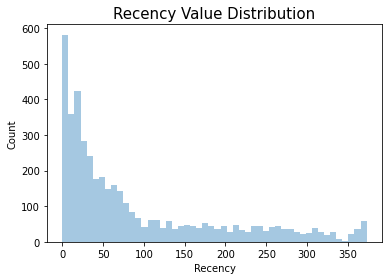

In [251]:
import seaborn as sns
sns.distplot(rfm_r['Recency'], kde=False, bins=50)
plt.title('Recency Value Distribution', fontsize = 15)
plt.xlabel('Recency')
plt.ylabel('Count');

**CLUSTERING WITH K-MEANS**

In [252]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [253]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(rfm_r)
    distortions.append(kmeanModel.inertia_)

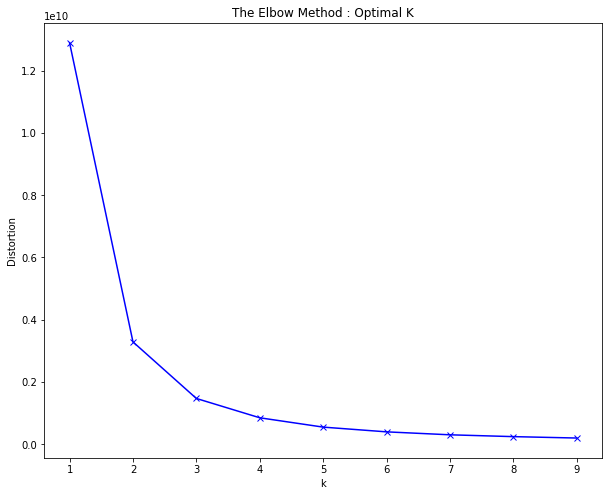

In [254]:
plt.figure(figsize=(10,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method : Optimal K')
plt.show()

In [255]:
preprocessor = Pipeline([
  ("scaler", MinMaxScaler())
])

In [256]:
clusterer = Pipeline(
   [
       (
          "kmeans",
           KMeans(
               n_clusters= 3,
               init="k-means++",
               random_state=42,
           ),
       ),
   ]
)

In [257]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [258]:
pipe.fit(rfm_r[['Recency']])

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=300,
                                         n_clusters=3, n_init=10, n_jobs=None,
                                         precompute_distances='auto',
                                         random_state=42, tol=0.0001,
                                         verbose=0))],
                          verbose=False))],
         verbose=False)

In [259]:
preprocessed_data = pipe["preprocessor"].transform(rfm_r[['Recency']])
labels_r = pipe["clusterer"]["kmeans"].labels_
rfm_r["RecencyCluster"] = labels_r
rfm_r.head()

,CustomerID,Recency,RecencyCluster
0,12346,325,1
1,12347,1,0
2,12348,74,0
3,12349,18,0
4,12350,309,1


In [260]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
silhouette_score(preprocessed_data, labels_r)

0.6747352836926265

In [261]:
rfm_r.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2906.0,31.163799,25.089417,0.0,10.0,24.0,50.00,91.0
1,626.0,293.431310,45.109849,224.0,256.0,286.5,325.75,373.0
2,806.0,152.400744,38.405673,92.0,118.0,151.5,185.00,222.0


In [262]:
def cluster_order(cluster, target, df, ascending):
    new_cluster = 'new_' + cluster
    df_new = df.groupby(cluster)[target].mean().reset_index()
    df_new = df_new.sort_values(by = target, ascending = ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_fin = pd.merge(df, df_new[[cluster,'index']], on=cluster)
    df_fin = df_fin.drop([cluster],axis=1)
    df_fin = df_fin.rename(columns={"index":cluster})
    return df_fin

In [263]:
rfm_r = cluster_order('RecencyCluster', 'Recency',rfm_r,False)
rfm_r.head()

,CustomerID,Recency,RecencyCluster
0,12346,325,0
1,12350,309,0
2,12354,231,0
3,12361,286,0
4,12365,290,0


In [264]:
rfm_r.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,626.0,293.431310,45.109849,224.0,256.0,286.5,325.75,373.0
1,806.0,152.400744,38.405673,92.0,118.0,151.5,185.00,222.0
2,2906.0,31.163799,25.089417,0.0,10.0,24.0,50.00,91.0


**FREQUENCY : NUMBER OF TRANSACTIONS**

In [265]:
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


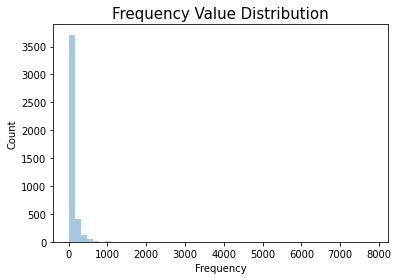

In [266]:
sns.distplot(rfm_f['Frequency'], kde=False, bins=50)
plt.title('Frequency Value Distribution', fontsize = 15)
plt.xlabel('Frequency')
plt.ylabel('Count');

**CLUSTERING WITH K-MEANS**

In [267]:
pipe.fit(rfm_f[['Frequency']])

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=300,
                                         n_clusters=3, n_init=10, n_jobs=None,
                                         precompute_distances='auto',
                                         random_state=42, tol=0.0001,
                                         verbose=0))],
                          verbose=False))],
         verbose=False)

In [268]:
preprocessed_data = pipe["preprocessor"].transform(rfm_f[['Frequency']])
labels_f = pipe["clusterer"]["kmeans"].labels_
rfm_f["FrequencyCluster"] = labels_f
rfm_f.head()

,CustomerID,Frequency,FrequencyCluster
0,12346,1,0
1,12347,182,0
2,12348,31,0
3,12349,73,0
4,12350,17,0


In [269]:
silhouette_score(preprocessed_data, labels_f)

0.8172792903095373

In [270]:
rfm_f.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4072.0,59.639244,60.203016,1.0,16.00,37.0,85.00,281.0
1,4.0,5807.000000,1429.730044,4595.0,4982.00,5393.0,6218.00,7847.0
2,262.0,503.072519,321.281281,282.0,327.25,405.5,540.25,2700.0


In [271]:
rfm_f = cluster_order('FrequencyCluster', 'Frequency',rfm_f,True)
rfm_f.head()

,CustomerID,Frequency,FrequencyCluster
0,12346,1,0
1,12347,182,0
2,12348,31,0
3,12349,73,0
4,12350,17,0


In [272]:
rfm_f.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4072.0,59.639244,60.203016,1.0,16.00,37.0,85.00,281.0
1,262.0,503.072519,321.281281,282.0,327.25,405.5,540.25,2700.0
2,4.0,5807.000000,1429.730044,4595.0,4982.00,5393.0,6218.00,7847.0


**MONETARY : TOTAL AMOUNT OF TRANSACTIONS**

In [273]:
df['Monetary'] = df['Quantity']*df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


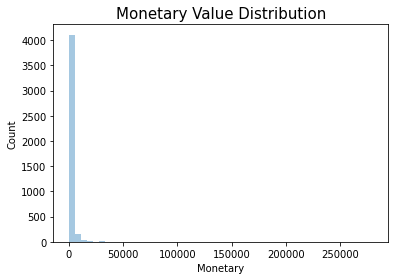

In [274]:
sns.distplot(rfm_m['Monetary'], kde=False, bins=50)
plt.title('Monetary Value Distribution', fontsize = 15)
plt.xlabel('Monetary')
plt.ylabel('Count');

In [275]:
pipe.fit(rfm_m[['Monetary']])

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=300,
                                         n_clusters=3, n_init=10, n_jobs=None,
                                         precompute_distances='auto',
                                         random_state=42, tol=0.0001,
                                         verbose=0))],
                          verbose=False))],
         verbose=False)

In [276]:
preprocessed_data = pipe["preprocessor"].transform(rfm_m[['Monetary']])
labels_m = pipe["clusterer"]["kmeans"].labels_
rfm_m["MonetaryCluster"] = labels_m
rfm_m.head()

,CustomerID,Monetary,MonetaryCluster
0,12346,77183.60,2
1,12347,4310.00,0
2,12348,1797.24,0
3,12349,1757.55,0
4,12350,334.40,0


In [277]:
silhouette_score(preprocessed_data, labels_m)

0.9615878134391025

In [278]:
rfm_m.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,4307.0,1480.796985,2463.849989,3.75,306.5050,665.86,1624.6300,28882.44
1,5.0,209342.334000,58598.003581,143825.06,168472.5000,194550.79,259657.3000,280206.02
2,26.0,57188.600769,24729.928330,31833.68,37844.5125,53030.72,65133.4975,124914.53


In [279]:
rfm_m = cluster_order('MonetaryCluster', 'Monetary',rfm_m,True)
rfm_m.head()

,CustomerID,Monetary,MonetaryCluster
0,12346,77183.60,1
1,12415,124914.53,1
2,12748,33719.73,1
3,12931,42055.96,1
4,13089,58825.83,1


In [280]:
rfm_m.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,4307.0,1480.796985,2463.849989,3.75,306.5050,665.86,1624.6300,28882.44
1,26.0,57188.600769,24729.928330,31833.68,37844.5125,53030.72,65133.4975,124914.53
2,5.0,209342.334000,58598.003581,143825.06,168472.5000,194550.79,259657.3000,280206.02


**MERGE RFM FACTORS**

In [281]:
rfm = pd.merge(pd.merge(rfm_r, rfm_f, on='CustomerID'), rfm_m, on='CustomerID')
rfm.columns = ['CustomerID', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'MonetaryCluster']
rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster
0,12346,325,0,1,0,77183.60,1
1,12350,309,0,17,0,334.40,0
2,12354,231,0,58,0,1079.40,0
3,12361,286,0,10,0,189.90,0
4,12365,290,0,22,0,641.38,0


**CALCULATE RFM SCORE**
* Recency : the **higher** the Recency value, the **higher** the score.
* Frequency : the **higher** the Frequency value, the **higher** the score.
* Monetary : the **higher** the Monetary value, the **higher** the score.

In [282]:
rfm['RFMScore'] = rfm['RecencyCluster'] + rfm['FrequencyCluster'] + rfm['MonetaryCluster']
rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore
0,12346,325,0,1,0,77183.60,1,1
1,12350,309,0,17,0,334.40,0,0
2,12354,231,0,58,0,1079.40,0,0
3,12361,286,0,10,0,189.90,0,0
4,12365,290,0,22,0,641.38,0,0


In [283]:
rfm['RFMScore'].unique()

array([1, 0, 2, 4, 3, 5, 6])

In [284]:
rfm['Membership'] = 'Bronze' 
rfm.loc[rfm['MonetaryCluster'] > 0, 'Membership'] = 'Silver' 
rfm.loc[rfm['MonetaryCluster'] > 1, 'Membership'] = 'Gold'
rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership
0,12346,325,0,1,0,77183.60,1,1,Silver
1,12350,309,0,17,0,334.40,0,0,Bronze
2,12354,231,0,58,0,1079.40,0,0,Bronze
3,12361,286,0,10,0,189.90,0,0,Bronze
4,12365,290,0,22,0,641.38,0,0,Bronze


   Bronze  Silver  Gold
     4307      26     5


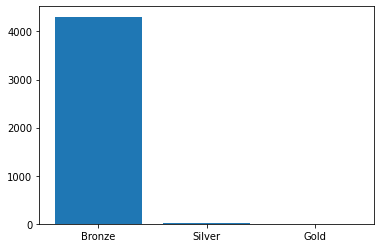

In [285]:
barplot = dict(rfm['Membership'].value_counts())
bar_names = list(barplot.keys())
bar_values = list(barplot.values())
plt.bar(bar_names,bar_values)
print(pd.DataFrame(barplot, index=[' ']))

# **Conclusion**

**1. Core - Your Best Customers**
* RFM Score : 222
* Who They Are : Highly engaged customers who have bought the most recent, the most often, and generated the most revenue.

In [286]:
core_cust = rfm[rfm['RFMScore'] == 6].sort_values('CustomerID', ascending=True)
core_cust.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership
1894,14911,0,2,5675,2,143825.06,2,6,Gold


In [287]:
core_cust['CustomerID'].count()

1

**2. Loyal - Your Most Loyal Customers**
* RFM Score : X2X
* Who They Are : Customers who buy the most often from your store.

In [288]:
loyal_cust = rfm[rfm['FrequencyCluster'] == 2].sort_values('Frequency', ascending=False)
loyal_cust.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership
3333,17841,1,2,7847,2,40991.57,1,5,Silver
1894,14911,0,2,5675,2,143825.06,2,6,Gold
1491,14096,3,2,5111,2,65164.79,1,5,Silver
858,12748,0,2,4595,2,33719.73,1,5,Silver


In [289]:
loyal_cust['CustomerID'].count()

4

Text(0.5, 1.0, 'Most Loyal Customer')

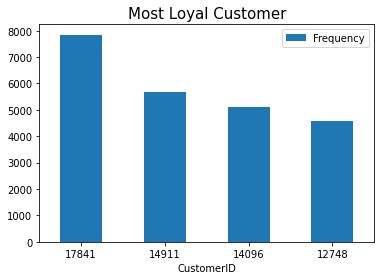

In [290]:
loyal_cust.plot.bar(x='CustomerID', y='Frequency', rot=0)
plt.title('Most Loyal Customer', size=15)

Text(0.5, 1.0, 'Most Loyal Customer')

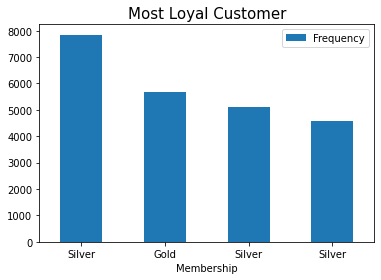

In [291]:
loyal_cust.plot.bar(x='Membership', y='Frequency', rot=0)
plt.title('Most Loyal Customer', size=15)

**3. Whales - Your Highest Paying Customers**
* RFM Score : XX2
* Who They Are : Customers who have generated the most revenue for your store.

In [292]:
whales_cust = rfm[rfm['MonetaryCluster'] == 2].sort_values('Monetary', ascending=False)
whales_cust.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership
1755,14646,1,2,2076,1,280206.02,2,5,Gold
3441,18102,0,2,431,1,259657.30,2,5,Gold
3137,17450,7,2,337,1,194550.79,2,5,Gold
2646,16446,0,2,3,0,168472.50,2,4,Gold
1894,14911,0,2,5675,2,143825.06,2,6,Gold


In [293]:
whales_cust['CustomerID'].count()

5

Text(0.5, 1.0, 'Highest Paying Customer')

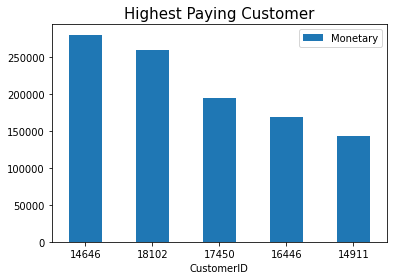

In [294]:
whales_cust.plot.bar(x='CustomerID', y='Monetary', rot=0)
plt.title('Highest Paying Customer', size=15)

Text(0.5, 1.0, 'Highest Paying Customer')

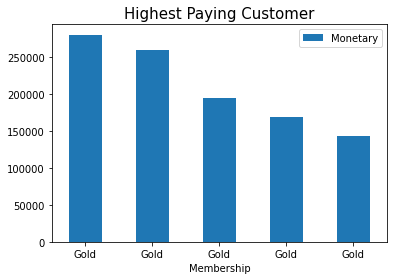

In [295]:
whales_cust.plot.bar(x='Membership', y='Monetary', rot=0)
plt.title('Highest Paying Customer', size=15)

**4. Rookies - Your Newest Customers**
* RFM Score : 20X
* Who They Are : First time buyers on your site.

In [296]:
rookies_cust = rfm[(rfm['RecencyCluster'] == 2) & (rfm['FrequencyCluster'] == 0)].sort_values('Monetary', ascending=False)
rookies_cust.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership
2646,16446,0,2,3,0,168472.50,2,4,Gold
2440,16029,38,2,242,0,81024.84,1,3,Silver
2760,16684,3,2,277,0,66653.56,1,3,Silver
3379,17949,0,2,70,0,58510.48,1,3,Silver
2309,15769,6,2,130,0,56252.72,1,3,Silver


In [297]:
rookies_cust['CustomerID'].count()

2645

Text(0.5, 1.0, 'Top 5 Newest Customer')

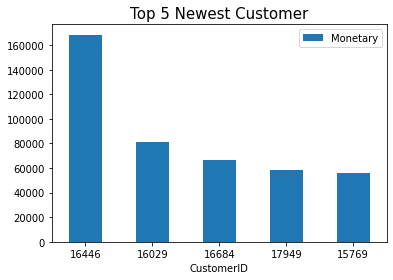

In [298]:
rookies_cust.head(5).plot.bar(x='CustomerID', y='Monetary', rot=0)
plt.title('Top 5 Newest Customer', size=15)

Text(0.5, 1.0, 'Top 5 Newest Customer')

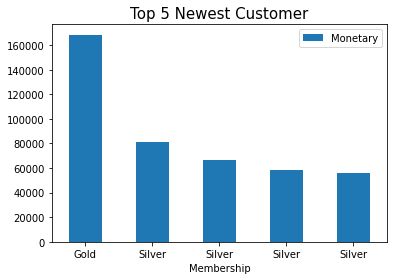

In [299]:
rookies_cust.head(5).plot.bar(x='Membership', y='Monetary', rot=0)
plt.title('Top 5 Newest Customer', size=15)

**5. Slipping - Once Loyal, Now Gone**
* RFM Score : 00X
* Who They Are : Great past customers who haven't bought in awhile.

In [300]:
slip_cust = rfm[(rfm['RecencyCluster'] == 0) & (rfm['FrequencyCluster'] == 0)].sort_values('Monetary', ascending=False)
slip_cust.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership
0,12346,325,0,1,0,77183.60,1,1,Silver
363,15749,234,0,10,0,44534.30,1,1,Silver
86,13093,275,0,159,0,7832.47,0,0,Bronze
272,15032,255,0,52,0,4959.10,0,0,Bronze
47,12755,280,0,4,0,3811.95,0,0,Bronze


In [301]:
slip_cust['CustomerID'].count()

625

Text(0.5, 1.0, 'Top 5 Slipping Customer')

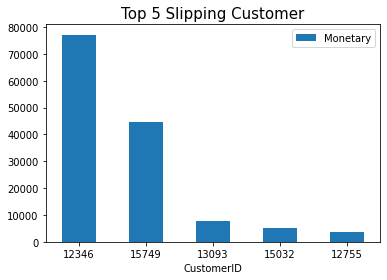

In [302]:
slip_cust.head(5).plot.bar(x='CustomerID', y='Monetary', rot=0)
plt.title('Top 5 Slipping Customer', size=15)

Text(0.5, 1.0, 'Top 5 Slipping Customer')

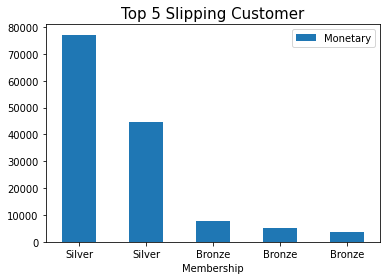

In [303]:
slip_cust.head(5).plot.bar(x='Membership', y='Monetary', rot=0)
plt.title('Top 5 Slipping Customer', size=15)

**6. Regular - The customers having common behaviour across these metrics.**
* RFM Score: Remaining Scores
* Who They Are: Customer who have average metrics across each RFM scores.

In [304]:
rfm['Status'] = 'Regular' 
rfm.loc[rfm['RFMScore'] == 6, 'Status'] = 'Core'
rfm.loc[rfm['FrequencyCluster'] == 2, 'Status'] = 'Loyal'
rfm.loc[rfm['MonetaryCluster'] == 2, 'Status'] = 'Whale'
rfm.loc[((rfm['RecencyCluster'] == 2) & (rfm['FrequencyCluster'] == 0)), 'Status'] = 'Rookies'
rfm.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership,Status
0,12346,325,0,1,0,77183.60,1,1,Silver,Regular
1,12350,309,0,17,0,334.40,0,0,Bronze,Regular
2,12354,231,0,58,0,1079.40,0,0,Bronze,Regular
3,12361,286,0,10,0,189.90,0,0,Bronze,Regular
4,12365,290,0,22,0,641.38,0,0,Bronze,Regular


In [305]:
reg_cust = rfm[rfm['Status'].str.contains('Regular', regex=False)].sort_values('Monetary', ascending=False)
reg_cust.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,RFMScore,Membership,Status
662,12415,23,2,714,1,124914.53,1,4,Silver,Regular
1521,14156,9,2,1400,1,117379.63,1,4,Silver,Regular
3164,17511,2,2,963,1,91062.38,1,4,Silver,Regular
0,12346,325,0,1,0,77183.60,1,1,Silver,Regular
1301,13694,3,2,568,1,65039.62,1,4,Silver,Regular


In [306]:
reg_cust['CustomerID'].count()

1686

Text(0.5, 1.0, 'Top 5 Regular Customer')

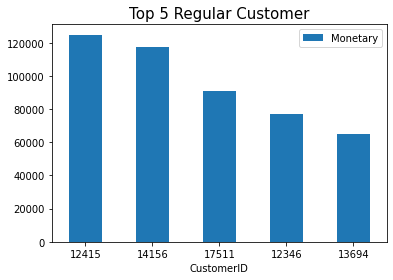

In [307]:
reg_cust.head(5).plot.bar(x='CustomerID', y='Monetary', rot=0)
plt.title('Top 5 Regular Customer', size=15)

Text(0.5, 1.0, 'Top 5 Regular Customer')

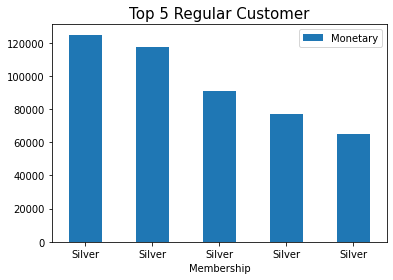

In [308]:
reg_cust.head(5).plot.bar(x='Membership', y='Monetary', rot=0)
plt.title('Top 5 Regular Customer', size=15)

In [309]:
pip install squarify

In [310]:
color_list = ['#0f7216', '#b2790c', '#ffe9a3',
              '#f9d4d4', '#d35158', '#ea3033']

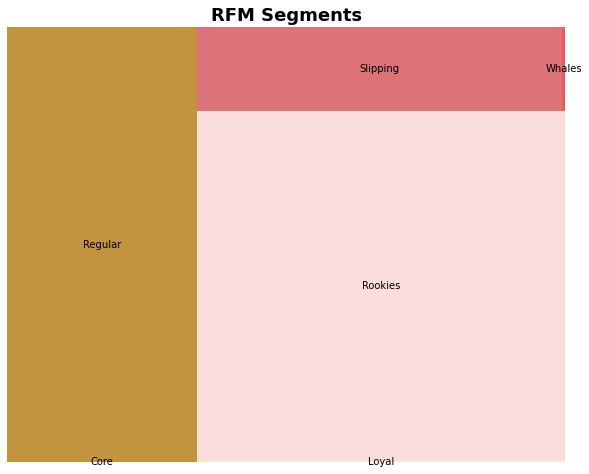

In [311]:
#Create our RFM Segment plot and resize it.
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 8)
squarify.plot(sizes=[core_cust['CustomerID'].count(),
                     reg_cust['CustomerID'].count(),
                     loyal_cust['CustomerID'].count(),
                     rookies_cust['CustomerID'].count(),
                     slip_cust['CustomerID'].count(),
                     whales_cust['CustomerID'].count()], 
              label=['Core',
                     'Regular',
                     'Loyal',
                     'Rookies',
                     'Slipping', 
                     'Whales'], alpha=0.8, color=color_list)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()